# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)


## 1. Introduction <a name="introduction"></a>

In this project we will try to find similarities between the cities of Berlin and Hamburg, Germany. Specifically, this report will be targeted to: 
* Citizens from either city, interested in moving to the other.
* Companies interested in relocating or expanding in either city.

Since there are lots of venues in Berlin and Hamburg, we will try to detect **neighborhoods that are similar to each other, by analyzing the most common venues**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final neighborhood can be chosen by the interested parties.

## 2. Data <a name="data"></a>

##### 2.1 Data sources

Based on definition of our problem, factors that will influence our decission are:
* number of existing venues in the neighborhood (any type)
* top 5 most common venues in the neighborhood

Following data sources will be needed to extract/generate the required information:

<b>1. City neighborhood and respective geographical data:</b>

In order to analyse the cities on a meaningfull level, they need to be divided into differen areas, e.g. neighborhoods, boroughs. Luckily both is available as a Github repro and can be found
<a href="https://github.com/zauberware/postal-codes-json-xml-csv">here</a>. This data includes 11 rows, of which only state (i.e. Berlin or Hamburg), ZIP-code (10 for Berlin, 22 for Hamburg), latitude and longitude per ZIP-code will be needed. ZIP-codes will be used for dividing both cities into smaller areas. ZIP-code is chosen as it is an unique identifier. In the following this data is cleaned and filtered to what is needed.

<b>2. Venue data:</b>

The first 100 venues per ZIP-code in both Hamburg and Berlin are scraped in order to cluster the different areas. This data, including the Venue name, its categroy, latitude and longitude, is gathered using the Foursquare API.

##### 2.2 Neighborhoods

First we need to import all the necessary libraries.

In [22]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1


Now let's import the location data of our relevant neighborhoods.

In [23]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell

# add missing __iter__ method, so pandas accepts body as file-like object 

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face an error during data loading.
# Please read the documentation of 'pandas.read_json()' and 'pandas.io.json.json_normalize' to learn more about the possibilities to adjust the data loading.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

df_data_2 = pd.read_json(body, orient='values')
df_data_2.head()

,country_code,zipcode,place,state,state_code,province,province_code,community,community_code,latitude,longitude
0,DE,1945,Grünewald,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4000,14.0000
1,DE,1945,Lindenau,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4000,13.7333
2,DE,1945,Hohenbocka,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4310,14.0098
3,DE,1945,Schwarzbach,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4500,13.9333
4,DE,1945,Guteborn,Brandenburg,BB,,0,Landkreis Oberspreewald-Lausitz,12066,51.4167,13.9333


##### 2.3 Data cleaning

Now we need to **filter** in order to keep only the relevant information.

In [24]:
#drop columns not needed and keep all ZIP-codes for the state of Berlin
Ber = df_data_2[['zipcode', 'state', 'latitude','longitude']].copy()
Ber = Ber[Ber.state == 'Berlin']
Ber.reset_index(drop = True, inplace = True)

Ham = df_data_2[['zipcode', 'state', 'latitude','longitude']].copy()
Ham = Ham[Ham.state == 'Hamburg']
Ham.drop_duplicates(subset=['zipcode'], keep='first', inplace = True)
Ham.reset_index(drop = True, inplace = True)

print(f'Shape of Berlin ZIP-code only dataframe: {Ber.shape}')

#drop columns not needed and keep all zipcodes for the state of Hamburg
Ham = df_data_2[['zipcode', 'state', 'latitude','longitude']].copy()
Ham = Ham[Ham.state == 'Hamburg']
Ham.drop_duplicates(subset=['zipcode'], keep='first', inplace = True)
Ham.reset_index(drop = True, inplace = True)
print(f'Shape of Hamburg ZIP-code only dataframe: {Ham.shape}')

#combine both data frames for Berlin and Hamburg
frames = [Ber, Ham]
BerHam = pd.concat(frames)
BerHam.reset_index(drop = True, inplace = True)
print(f'Shape of filtered data frame including all ZIP-codes for Berlin and Hamburg: {BerHam.shape}')
BerHam.head()

Shape of Berlin ZIP-code only dataframe: (195, 4)
Shape of Hamburg ZIP-code only dataframe: (101, 4)
Shape of filtered data frame including all ZIP-codes for Berlin and Hamburg: (296, 4)


,zipcode,state,latitude,longitude
0,10115,Berlin,52.5323,13.3846
1,10117,Berlin,52.5170,13.3872
2,10119,Berlin,52.5305,13.4053
3,10178,Berlin,52.5213,13.4096
4,10179,Berlin,52.5122,13.4164


##### 2.4 Foursquare API

Now we need to set up the Foursquare API as to scrape the venues based on zipcode.

In [25]:
#utilizing the Foursquare API to explore the neighborhoods and segment them


#function to retrieve first 100 avenues per ZIP-code in Berlin and Hamburg
LIMIT = 100

def getNearbyVenues(zipcode, state, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for zipcode, state, lat, lng in zip(zipcode, state, latitudes, longitudes):
        print(zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            state,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode',
                  'State',
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#run the above function on each neighborhood and create a new dataframe called toronto_venues
venues_BerHam = getNearbyVenues(zipcode = BerHam['zipcode'],
                                   state = BerHam['state'],
                                   latitudes = BerHam['latitude'],
                                   longitudes = BerHam['longitude']
                                  )



10115
10117
10119
10178
10179
10243
10245
10247
10249
10315
10317
10318
10319
10365
10367
10369
10405
10407
10409
10435
10437
10439
10551
10553
10555
10557
10559
10585
10587
10589
10623
10625
10627
10629
10707
10709
10711
10713
10715
10717
10719
10777
10779
10781
10783
10785
10787
10789
10823
10825
10827
10829
10961
10963
10965
10967
10969
10997
10999
11011
12043
12045
12047
12049
12051
12053
12055
12057
12059
12099
12101
12103
12105
12107
12109
12157
12159
12161
12163
12165
12167
12169
12203
12205
12207
12209
12247
12249
12277
12279
12305
12307
12309
12347
12349
12351
12353
12355
12357
12359
12435
12437
12439
12459
12487
12489
12524
12526
12527
12529
12555
12557
12559
12587
12589
12619
12621
12623
12627
12629
12679
12681
12683
12685
12687
12689
13047
13051
13053
13055
13057
13059
13086
13088
13089
13125
13127
13129
13156
13158
13159
13187
13189
13347
13349
13351
13353
13355
13357
13359
13403
13405
13407
13409
13435
13437
13439
13465
13467
13469
13503
13505
13507
13509
13581
13583
1358

In [26]:
##Venues in Berlin and Hamburg data frame overview
print(f'Shape: {venues_BerHam.shape}')
venues_BerHam_clean = venues_BerHam.copy()
venues_BerHam_clean.drop_duplicates('Venue', keep='first', inplace=True)
venues_BerHam_clean.sort_values(by = 'Zipcode', inplace = True)
print(f'Shape: {venues_BerHam_clean.shape}')
venues_BerHam_clean.reset_index([0], drop = True, inplace = True)
unique_venues = venues_BerHam_clean['Venue Category'].nunique()
print(f'Total number of venues: {venues_BerHam_clean.shape[0]}')
print(f'Total number of venue categories: {unique_venues}')
venues_BerHam_clean.head(10)

Shape: (13551, 8)
Shape: (6934, 8)
Total number of venues: 6934
Total number of venue categories: 427


,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,Berlin,52.5323,13.3846,Hotel i31,52.531107,13.384270,Hotel
1,10115,Berlin,52.5323,13.3846,Hotel ULTRA Concept Store,52.529362,13.396969,Furniture / Home Store
2,10115,Berlin,52.5323,13.3846,Deutsches Theater,52.523970,13.382001,Theater
3,10115,Berlin,52.5323,13.3846,Ackerstadtpalast,52.529721,13.396777,Performing Arts Venue
4,10115,Berlin,52.5323,13.3846,Sammlung Boros,52.523352,13.384213,Art Gallery
5,10115,Berlin,52.5323,13.3846,Factory Kitchen,52.537449,13.394714,Restaurant
6,10115,Berlin,52.5323,13.3846,Hamburger Bahnhof – Museum für Gegenwart,52.528513,13.372067,Art Museum
7,10115,Berlin,52.5323,13.3846,Du Bonheur,52.536310,13.397558,Pastry Shop
8,10115,Berlin,52.5323,13.3846,Bandol sur Mer,52.528992,13.395436,French Restaurant
9,10115,Berlin,52.5323,13.3846,H Gedenkstätte Berliner Mauer,52.535750,13.390708,Tram Station


The data is scraped, aggregated and summarized. Next step is to start analyzing each neighborhood seperately in order to prepare forclustering.

In [27]:
#number of venues were returned for each ZIP-code in Berlin and Hamburg
venues_BerHam_clean.groupby(['Zipcode'],as_index = False).count().head()

,Zipcode,State,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10115,99,99,99,99,99,99,99
1,10117,91,91,91,91,91,91,91
2,10119,89,89,89,89,89,89,89
3,10178,64,64,64,64,64,64,64
4,10179,76,76,76,76,76,76,76


In [28]:
#one hot encoding to analyze each ZIP-Code
onehot_BerHam = pd.get_dummies(venues_BerHam_clean[['Venue Category']], prefix="", prefix_sep="")

# add ZIP-code and state column back to dataframe
onehot_BerHam['Zipcode'] = venues_BerHam_clean['Zipcode']
onehot_BerHam['State'] = venues_BerHam_clean['State']

# move ZIP-code and State column to the first column
fixed_columns = [onehot_BerHam.columns[-1]] + list(onehot_BerHam.columns[:-1])
onehot_BerHam = onehot_BerHam[fixed_columns]
fixed_columns = [onehot_BerHam.columns[-1]] + list(onehot_BerHam.columns[:-1])
onehot_BerHam = onehot_BerHam[fixed_columns]
onehot_BerHam.reset_index([0], drop = True, inplace = True)

print(f'Shape: {onehot_BerHam.shape}')
onehot_BerHam.head()

Shape: (6934, 429)


,Zipcode,State,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bath House,Bathing Area,Bavarian Restaurant,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat Rental,Boat or Ferry,Bookstore,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Arts Building,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Creperie,Cultural Center,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Imported Food Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Kofte Place,Korean Restaurant,Kumpir Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Paella Restaurant,Paintball Field,Pakistani Restaurant,Palace,Palatin

## 3. Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Berlin that have similarities in the types of venues with areas in Hamburg.

In the first step we have collected the required data: **location and type (category) of every venue within Berlin and Hamburg**. We have also **identified and analyzed venues in every ZIP-Code** (according to Foursquare categorization).

Second step in our analysis will be the calculation and exploration of '**venue similarity**' across the two cities - we will use **barcharts** to identify the top venue categories in both cities and focus our attention on areas with those types of venues.

In the third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two restaurants in radius of 250 meters**, and we want locations **without Italian restaurants in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## 4. Analysis <a name="analysis"></a>

##### 4.1 Analyze top venue categories

In [29]:
# Import Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#select plotting style
print(plt.style.available)
mpl.style.use(['ggplot'])

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


(20, 3)


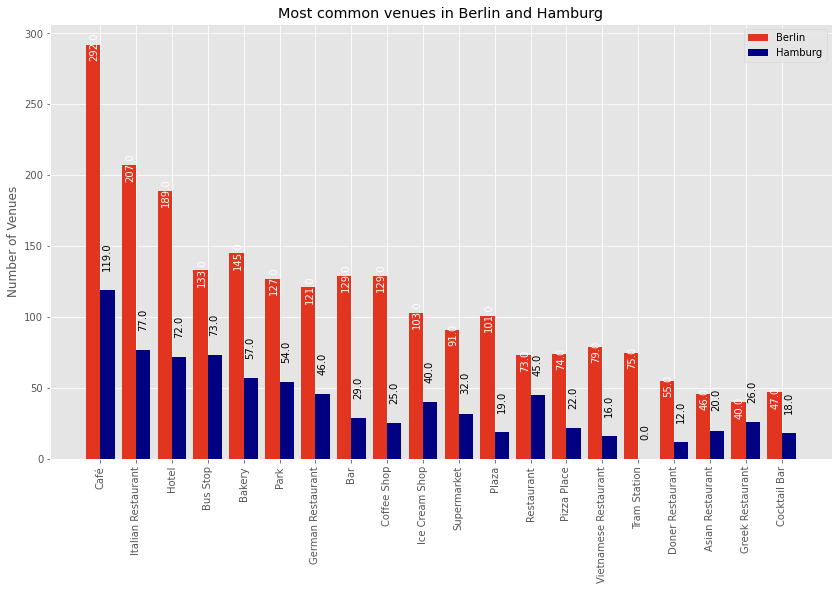

In [30]:
# counting returned venues per city
venue_count = onehot_BerHam.groupby('State').sum().reset_index()
venue_count.drop('Zipcode', axis = 1, inplace = True)
venue_count = venue_count.set_index('State').transpose()
venue_count['Total'] = venue_count.sum(axis=1)
venue_count.sort_values(by = ['Total'], inplace = True, ascending = False)

#filter for top 20 venues and sort
venue_count_top20 = venue_count.head(20)
print(venue_count_top20.shape)
venue_count_top20.reset_index(inplace = True)
venue_count_top20.columns = ['Venue', 'Berlin', 'Hamburg', 'Total']

#visualize top 20 venues
X = np.arange(20)
width = 0.4

plt.figure(figsize=(14,8), facecolor = 'white')

plt.bar(X + 0.00, venue_count_top20['Berlin'], color = '#e23520', width = width)
plt.bar(X + width, venue_count_top20['Hamburg'], color = '#000180', width = width)

plt.ylabel('Number of Venues')
plt.title('Most common venues in Berlin and Hamburg')

for s, d in zip(X, venue_count_top20['Berlin']):
    plt.annotate(venue_count_top20.Berlin[s], xy = (s-0.1,d-10), rotation=90, color='white')
for s, d in zip(X, venue_count_top20['Hamburg']):
    plt.annotate(venue_count_top20.Hamburg[s], xy = (s+0.25,d+15), rotation=90, color='black')

plt.xticks(X + width / 2, venue_count_top20['Venue'], rotation='vertical')
plt.legend(labels=venue_count_top20.columns[1:3], loc='best')

plt.show()

Since Berlin is roughly twice the size of Hamburg (BER ZIP-Codes: 195, HAM ZIP-Codes: 101), it makes sense to observe an overall higher amount of venues.

Regarding this, there are a few points to be raised:

* <b>Cafés</b> are most common in both cities, which makes sense since restaurants are further categorized in sub-categories (e.g. italian, chinese, etc.)
* The amount of <b>bars</b> in Berlin is almost 5 times that of Hamburg.
* There are substantially more <b>ice cream shops</b> in Berlin. Maybe that's an indication about the weather conditions in both cities.
* We observe that there may be <b>bus stops</b> in Hamburg, but not <b>tram stations</b> which is the case in Berlin.

It might make more sense if we normalize the data by dividing with the number of residents in both cities.

<i>As of 2019:
    
    * Berlin: 3,65 mil. residents
    * Hamburg: 1,81 mil. residents
</i>


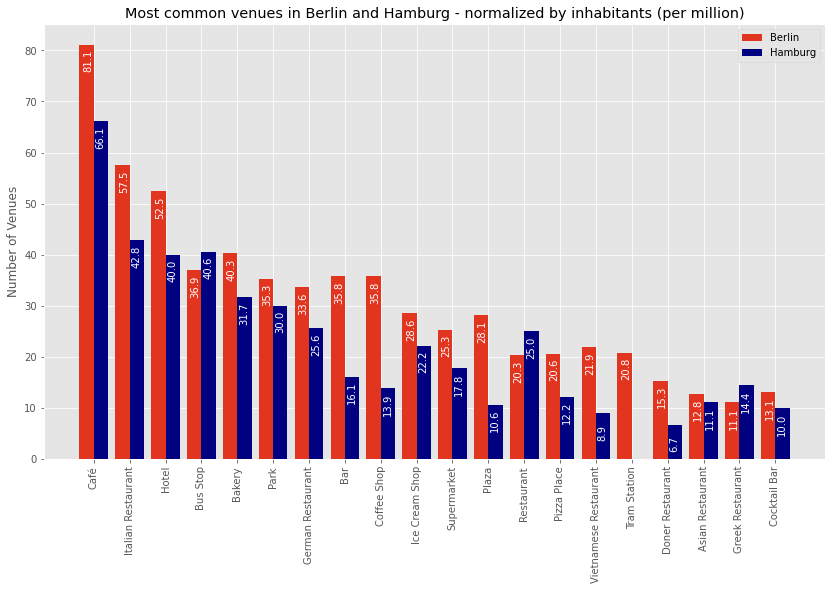

In [31]:
#data needs to be normalized based on inhabitans (Berlin ~ 3.6 mil, Hamburg ~ 1.8) 
venue_count_ntop20 = venue_count_top20.copy()
venue_count_ntop20['Berlin'] = venue_count_top20['Berlin'] / 3.6
venue_count_ntop20['Hamburg'] = venue_count_top20['Hamburg'] / 1.8
venue_count_ntop20 = venue_count_ntop20.round(1)

#visualize top 20 venues using normalized data
X = np.arange(20)
width = 0.4

plt.figure(figsize=(14,8))

plt.bar(X + 0.00, venue_count_ntop20['Berlin'], color = '#e23520', width = width)
plt.bar(X + width, venue_count_ntop20['Hamburg'], color = '#000180', width = width)

plt.ylabel('Number of Venues')
plt.title('Most common venues in Berlin and Hamburg - normalized by inhabitants (per million)')

for s, d in zip(X, venue_count_ntop20['Berlin']):
    plt.annotate(venue_count_ntop20.Berlin[s], xy = (s-0.1,d-5), rotation=90, color='white')
for s, d in zip(X, venue_count_ntop20['Hamburg']):
    plt.annotate(venue_count_ntop20.Hamburg[s], xy = (s+0.25,d-5), rotation=90, color='white')

plt.xticks(X + width / 2, venue_count_ntop20['Venue'], rotation='vertical')
plt.legend(labels=venue_count_ntop20.columns[1:3], loc='best')

plt.show()


Normalization of the data confirms, that Berlin has more venues per residents for the most common 20 venue categories. It also confirms the initial annotations about bars and coffe shops, which occur exceptionally often in Berlin. Furthermore, the high amount of bus stops per residents in Hamburg seem to make up for the missing tram stations. By normalizing our data we also disproved the assumption about ice cream shops, since the difference is not that significant.

In [32]:
#group rows by ZIP-code and analyze by the mean of the frequency of occurrence for each category
grouped_BerHam = onehot_BerHam.groupby('Zipcode').mean().reset_index()
print(f'Shape: {grouped_BerHam.shape}')

Shape: (267, 428)


##### 4.2 Clustering

The final data frame is used to analyze the ZIP-codes: clustering in order to find similarity in areas from Hamburg and Berlin.

Clustering is used for segmentation of the different ZIP-codes and is one of the unsupervised mashine learning methods. Each cluster is a group of objects (i.e. ZIP-code) that are similar to other objects in the cluster, and dissimilar to data points in other clusters.

For this analysis k-Means clustering is used. k-Means is a type of partition-based clustering in order to partitioning the data base into groups of individuals with similar characteristics. It divides data into non-overlapping subsets (clusters) without any cluster-internal structure. k-Means tries to minimize intra-cluster distances (e.g. Euclidean or other methods for measuring of distance) and maximize inter-cluster distances. It is an iterative algorithm, but the results depend on the initial defined number of clusters. In turn, this means that results (i.e. clusters) are guaranteed, but may be the optimum. Therefore, the algorithm will be run several times with different amount of initialy defined clusters. The algorythm returns inertia, or cost, which can be recognized as a measure of how internally coherent clusters are. 

In [33]:
#find best k

cluster_BerHam = grouped_BerHam.drop('Zipcode', 1)

best_k = []
for k in range (1, 25):
 
    # Create a kmeans model for our data.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(cluster_BerHam.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    best_k.append([k,interia])
    print ("k:",k, " cost:", interia)
best_k = pd.DataFrame(best_k)
best_k.columns = ['k', 'Cost']
best_k

k: 1  cost: 31.411738939979962
k: 2  cost: 29.17512022538296
k: 3  cost: 27.93318312699977
k: 4  cost: 26.953625618445297
k: 5  cost: 26.06333281604945
k: 6  cost: 25.35470620051459
k: 7  cost: 24.973039524750682
k: 8  cost: 23.927760093879307
k: 9  cost: 22.992646614789752
k: 10  cost: 22.70807427875297
k: 11  cost: 22.285819748168006
k: 12  cost: 21.902745387074546
k: 13  cost: 21.597440402056687
k: 14  cost: 20.66289890539852
k: 15  cost: 20.795345392755948
k: 16  cost: 20.311051730207474
k: 17  cost: 20.086581357682753
k: 18  cost: 19.52938931079433
k: 19  cost: 19.074906903755103
k: 20  cost: 18.91980700397203
k: 21  cost: 18.477108192717456
k: 22  cost: 18.70610712934482
k: 23  cost: 18.3028732766526
k: 24  cost: 17.95351669306156


,k,Cost
0,1,31.411739
1,2,29.175120
2,3,27.933183
3,4,26.953626
4,5,26.063333
5,6,25.354706
6,7,24.973040
7,8,23.927760
8,9,22.992647
9,10,22.708074


Right of the bat, we can observe the problem with k-Means: 

Increasing k always reduces inertia / cost. 

Therefore, the value of cost as a function of k is plotted and an 'elbow' point is determined where the rate of decrease sharply shifts. This is selected as the right k for clustering (elbow method).

<function matplotlib.pyplot.show(close=None, block=None)>

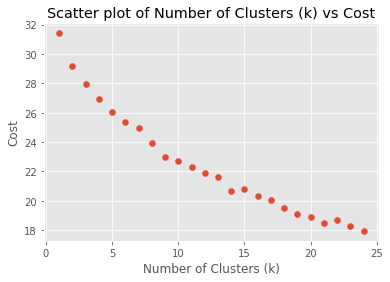

In [34]:
#plot cost values of k's as calculated above, to find best k value ('elbow')
plt.scatter(best_k['k'],best_k['Cost'])
plt.title("Scatter plot of Number of Clusters (k) vs Cost")
plt.ylabel("Cost")
plt.xlabel("Number of Clusters (k)")
plt.show

The elbow is clearly being formed when k = 15.

In [35]:
# set number of clusters
kclusters = 15

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_BerHam)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 7, 14,  7, 14, 14, 14,  7,  7,  7,  2], dtype=int32)

In [36]:
#First we write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#create the new dataframe and display the top 10 venues for each ZIP-code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
BerHam_venues_sorted = pd.DataFrame(columns=columns)
BerHam_venues_sorted['Zipcode'] = grouped_BerHam['Zipcode']

for ind in np.arange(grouped_BerHam.shape[0]):
    BerHam_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_BerHam.iloc[ind, :], num_top_venues)

#new dataframe that includes the cluster as well as the top 10 venues for each ZIP-code
# add clustering labels
BerHam_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged_BerHam = BerHam

# merge grouped_BerHam with BerHam to add latitude/longitude for each ZIP-code
merged_BerHam = merged_BerHam.join(BerHam_venues_sorted.set_index('Zipcode'), on='zipcode')

merged_clean_BerHam = merged_BerHam.dropna(subset=['Cluster Labels'], axis = 0, inplace = False)
merged_clean_BerHam = merged_clean_BerHam.astype({'Cluster Labels': int})

print(f'Shape Berlin & Hamburg: {merged_clean_BerHam.shape}')
merged_clean_BerHam.head()

Shape Berlin & Hamburg: (267, 15)


,zipcode,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10115,Berlin,52.5323,13.3846,7,Café,Restaurant,Coffee Shop,Hotel,Art Gallery,Pastry Shop,French Restaurant,Italian Restaurant,Middle Eastern Restaurant,Falafel Restaurant
1,10117,Berlin,52.5170,13.3872,14,Hotel,History Museum,Plaza,Chocolate Shop,Exhibit,Monument / Landmark,Concert Hall,Theater,Restaurant,Department Store
2,10119,Berlin,52.5305,13.4053,7,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Café,Bookstore,Vegetarian / Vegan Restaurant,Sandwich Place,Vietnamese Restaurant,Bistro
3,10178,Berlin,52.5213,13.4096,14,Hotel,Plaza,Café,Bookstore,Gym / Fitness Center,Scenic Lookout,Indie Movie Theater,Coffee Shop,German Restaurant,Sushi Restaurant
4,10179,Berlin,52.5122,13.4164,14,Hotel,Nightclub,Bakery,Café,Thai Restaurant,Event Space,Beer Garden,Bistro,Art Gallery,Bar


In [37]:
#Use geopy library to get the latitude and longitude values of Berlin and Hamburg

address_Ber = 'Berlin'

geolocator_Ber = Nominatim(user_agent="ber_explorer")
location_Ber = geolocator_Ber.geocode(address_Ber)
latitude_Ber = location_Ber.latitude
longitude_Ber = location_Ber.longitude
print(f'The geographical coordinates of Berlin are {latitude_Ber}, {longitude_Ber}.')


address_Ham = 'Hamburg'

geolocator_Ham = Nominatim(user_agent="ham_explorer")
location_Ham = geolocator_Ham.geocode(address_Ham)
latitude_Ham = location_Ham.latitude
longitude_Ham = location_Ham.longitude
print(f'The geographical coordinates of Hamburg are {latitude_Ham}, {longitude_Ham}.')

latitude_mid = (latitude_Ham + latitude_Ber) / 2
longitude_mid = (longitude_Ham + longitude_Ber) / 2

print(f'The geographical middle between both cities is: {latitude_mid}, {longitude_mid}')

The geographical coordinates of Berlin are 52.5170365, 13.3888599.
The geographical coordinates of Hamburg are 53.550341, 10.000654.
The geographical middle between both cities is: 53.03368875, 11.69475695


In [38]:
# create map for Berlin/Hamburg
map_BerHam_clusters = folium.Map(location=[latitude_mid, longitude_mid], zoom_start=8.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_clean_BerHam['latitude'], merged_clean_BerHam['longitude'], merged_clean_BerHam['zipcode'], merged_clean_BerHam['Cluster Labels']): #for clustering add cluster here
    label = folium.Popup('ZIP-code: ' + str(poi) + ' -- Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_BerHam_clusters)
       
map_BerHam_clusters

In [39]:
#show number of ZIP-codes per cluster
merged_clean_BerHam.sort_values(by = ['Cluster Labels'], inplace = True)
cluster_count = merged_clean_BerHam['Cluster Labels'].value_counts()
cluster_count = pd.DataFrame(cluster_count).reset_index()
cluster_count.columns = ['Cluster','ZIP-codes']
cluster_count.sort_values(by = 'Cluster')

,Cluster,ZIP-codes
4,0,12
9,1,1
5,2,10
6,3,5
3,4,13
10,5,1
11,6,1
0,7,99
2,8,42
8,9,2


## 5. Conclusion <a name="conclusion"></a>

It's certainly clear, that there are some clusters with more ZIP-Codes and others that only have 1.

It's a result that can be expected, since some neighborhoods share the same structure (e.g. predominantly housing, office etc.). Those neighborhoods fall into the same cluster, as they share a similar venue structure. 

Purple, red, yellow and dark blue are some of the clusters with many neighborhoods.
Neighborhoods that populate cluster 1 (purple) are observed around the city centers, while others (dark blue, yellow) are more peripheral, indicating -probably heavily weighted- housing areas.


To get deeper insights into what makes each cluster different, check out the full table below. 

Thank you for your patience. Feedback is encouraged and appreciated.

In [40]:
merged_clean_BerHam.head(100)

,zipcode,state,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
135,13125,Berlin,52.6329,13.4829,0,Asian Restaurant,Bus Stop,Light Rail Station,ATM,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop
226,21077,Hamburg,53.4319,10.0094,0,Bus Stop,Bowling Alley,Greek Restaurant,Pizza Place,Scenic Lookout,ATM,Pakistani Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza
87,12249,Berlin,52.4264,13.3518,0,Bus Stop,Recreation Center,Bakery,Soccer Field,IT Services,Fast Food Restaurant,Supermarket,Italian Restaurant,Palatine Restaurant,Persian Restaurant
219,21031,Hamburg,53.5089,10.1983,0,Steakhouse,Bus Stop,Hotel,Greek Restaurant,Paella Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop,Park
234,22043,Hamburg,53.5691,10.1209,0,Bus Stop,Rental Car Location,Ice Cream Shop,Intersection,Park,Greek Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza
270,22399,Hamburg,53.6539,10.0486,0,Automotive Shop,Soccer Field,Bus Stop,ATM,Pakistani Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop
253,22177,Hamburg,53.6158,10.0572,0,Shopping Mall,Cemetery,Bus Stop,Pakistani Restaurant,Peruvian Restaurant,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop
89,12279,Berlin,52.4106,13.3531,0,Bus Stop,Italian Restaurant,Supermarket,ATM,Paintball Field,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop
170,13593,Berlin,52.5148,13.1672,0,Bus Stop,Bakery,Italian Restaurant,ATM,Paintball Field,Persian Restaurant,Perfume Shop,Performing Arts Venue,Pedestrian Plaza,Pastry Shop
169,13591,Berlin,52.5345,13.1405,0,Bus Stop,Train Station,Turkish Restaurant,Cosmetics Shop,Restaurant,Eastern European Restaurant,Italian Restaurant,Perfume Shop,Palatine Restaurant,Performing Arts Venue
